# Detect and classify traffic light with pre-trained object detection model (and without re-training the model)

In this work I show a work flow of traffic light detection and classification by using a pretrained object detection model. This model has the two steps:

1. Locate the object detection boxes of traffic lights using a pretrained object detection model
2. In each detected image box, classify the color of traffic light by human intelligence, or aka. classical computer vsion approach.

This is a "lazy" solution because I didn't train any new machine learning model, just use some classical algorithmic away to classify the color of traffic lights.

References:
- [Tensorflow object detection tutorial](https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb)

In [1]:
%load_ext autoreload
%autoreload 2

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import os
#import tensorflow as tf
import tensorflow.compat.v1 as tf
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import cv2

show python version

In [3]:
import sys
print(sys.version)

3.7.7 (default, Mar 26 2020, 10:32:53) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


In [4]:
print(tf.__version__)

2.0.0


In [5]:
# This is needed to display the images.
%matplotlib inline

# Identify the traffic lights in an image

### Download pretrained model

In [6]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
model_path = "./"
PATH_TO_CKPT = model_path + MODEL_NAME + '/frozen_inference_graph.pb'


def download_model():
    import six.moves.urllib as urllib
    import tarfile

    opener = urllib.request.URLopener()
    opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
    tar_file = tarfile.open(MODEL_FILE)
    for file in tar_file.getmembers():
        file_name = os.path.basename(file.name)
        if 'frozen_inference_graph.pb' in file_name:
            tar_file.extract(file, os.getcwd())

### Code for doing detection

In [7]:
def load_graph():
    if not os.path.exists(PATH_TO_CKPT):
        download_model()

    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')

    return detection_graph

def select_boxes(boxes, classes, scores, score_threshold=0, target_class=10):
    """

    :param boxes:
    :param classes:
    :param scores:
    :param target_class: default traffic light id in COCO dataset is 10
    :return:
    """

    sq_scores = np.squeeze(scores)
    sq_classes = np.squeeze(classes)
    sq_boxes = np.squeeze(boxes)

    sel_id = np.logical_and(sq_classes == target_class, sq_scores > score_threshold)

    return sq_boxes[sel_id]

class TLClassifier(object):
    def __init__(self):

        self.detection_graph = load_graph()
        self.extract_graph_components()
        self.sess = tf.Session(graph=self.detection_graph)

        # run the first session to "warm up"
        dummy_image = np.zeros((100, 100, 3))
        self.detect_multi_object(dummy_image,0.1)
        self.traffic_light_box = None
        self.classified_index = 0

    def extract_graph_components(self):
        # Definite input and output Tensors for detection_graph
        self.image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        self.detection_boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        self.detection_scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
        self.detection_classes = self.detection_graph.get_tensor_by_name('detection_classes:0')
        self.num_detections = self.detection_graph.get_tensor_by_name('num_detections:0')
    
    def detect_multi_object(self, image_np, score_threshold):
        """
        Return detection boxes in a image

        :param image_np:
        :param score_threshold:
        :return:
        """

        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
        # Actual detection.

        (boxes, scores, classes, num) = self.sess.run(
            [self.detection_boxes, self.detection_scores, self.detection_classes, self.num_detections],
            feed_dict={self.image_tensor: image_np_expanded})

        sel_boxes = select_boxes(boxes=boxes, classes=classes, scores=scores,
                                 score_threshold=score_threshold, target_class=10)

        return sel_boxes


'''python
from detect_traffic_light import \
    high_saturation_region_mask, high_value_region_mask,\
get_mean_hue_value,channel_percentile,low_saturation_region_mask,low_value_region_mask,\
convert_to_hue_angle,classify_color_by_range
'''

In [8]:
project_dir = "/Users/Georg/Dropbox/Work/projects/2020_09_05_hackathon_zurich"
directory_name = f"{project_dir}/data/Dataset_complete/Trackpictures/nice_weather/nice_weather_filisur_thusis_20200824_pixelated"
results_dir = f"{project_dir}/data/results/nice_weather_images_detected"

In [9]:
%time
#test_file = "traffic_light_data/sample-dayClip6/sample-dayClip6/frames/dayClip6--00332.jpg"
test_file = f"{directory_name}/image_01231.jpg"
from PIL import Image
im = Image.open(test_file)
image_np = np.asarray(im)
image_np = image_np[:,:,:3]

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


In [10]:
def load_image(directory_name, fn):
    im = Image.open(directory_name + "/" + fn)
    image_np = np.asarray(im)
    image_np = image_np[:,:,:3]
    return image_np

def save_detected_image(image_np, boxes, dir_name, fn, dist):
    fig,ax = plt.subplots(1)
    ax.imshow(image_np)
    if len(boxes) > 0:
        for box in boxes:
            rect = get_rectangle(image_np, box)
            ax.add_patch(rect)
    plt.text(x = 50, y = 50, s = f"{round(dist)} m", bbox=dict(facecolor='white', alpha=0.5)) 
    plt.savefig(f'{dir_name}/{fn}')
    plt.close()
    
def get_rectangle(image_np, sel_box):
    im_height, im_width, _ = image_np.shape
    (left, right, top, bottom) = (sel_box[1] * im_width, sel_box[3] * im_width,
                                  sel_box[0] * im_height, sel_box[2] * im_height)
    box_width = right - left
    box_height = bottom - top
    return patches.Rectangle((left, top), box_width, box_height,linewidth=1,edgecolor='r',facecolor='none')

In [15]:
image_geotags_gdf = pd.read_csv(f"{project_dir}/data/results/distance_to_next_signal.csv")

In [16]:
image_names = pd.Series([fn for fn in os.listdir(directory_name) if "image" in fn])

In [17]:
tlc=TLClassifier()

In [18]:
for fn in image_names.sort_values()[:1000]:
    image_np = load_image(directory_name, fn)
    dist = image_geotags_gdf.query(f"fn=='{fn}'").distance_to_next_signal.iloc[0]
    boxes=tlc.detect_multi_object(image_np,score_threshold=0.1)
    save_detected_image(image_np, boxes, results_dir, fn, dist)

In [ ]:
image_geotags_gdf.head()

In [21]:
image_geotags_gdf.query(f"fn=='{fn}'")

,fn,lat,lon,geometry,signal_idx,increment,distance_to_next_signal


In [31]:
from PIL import Image, ImageEnhance

In [44]:
fn = "image_01286.jpg"
#dist = image_geotags_gdf.query(f"fn=='{fn}'").distance_to_next_signal.iloc[0]
#image_np = load_image(directory_name, fn)

im = Image.open(directory_name + "/" + fn)
image_np = np.asarray(im)
image_np = image_np[:,:,:3]

In [32]:
im = Image.open(directory_name + "/" + fn)

In [33]:
enhancer = ImageEnhance.Contrast(im)

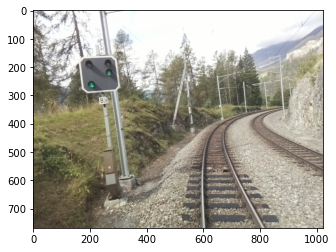

In [34]:
fig,ax = plt.subplots(1)
ax.imshow(im)
plt.show()

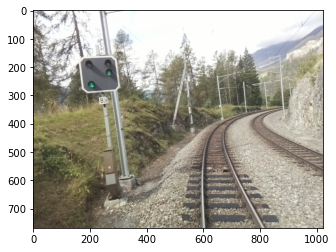

In [35]:
factor = 1 #gives original image
im_output = enhancer.enhance(factor)
fig,ax = plt.subplots(1)
ax.imshow(im_output)
plt.show()

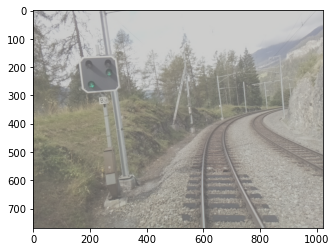

In [36]:
factor = 0.5 #gives original image
im_output = enhancer.enhance(factor)
fig,ax = plt.subplots(1)
ax.imshow(im_output)
plt.show()

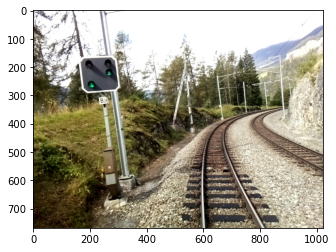

In [37]:
factor = 1.5 #gives original image
im_output = enhancer.enhance(factor)
fig,ax = plt.subplots(1)
ax.imshow(im_output)
plt.show()

In [45]:
hsv = cv2.cvtColor(image_np, cv2.COLOR_BGR2HSV)

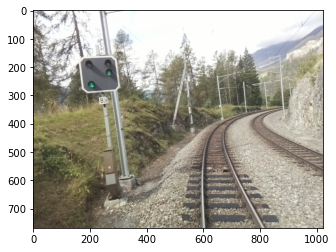

In [46]:
fig,ax = plt.subplots(1)
ax.imshow(image_np)
plt.show()

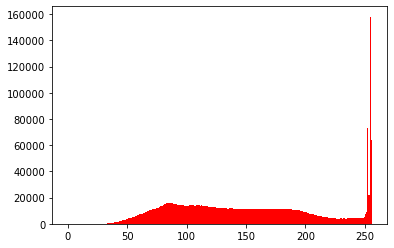

In [55]:
plt.hist(image_np.flatten(),256,[0,256], color = 'r')
plt.show()

ValueError: array([[[179, 133, 129],
        [182, 133, 129],
        [217, 132, 129],
        ...,
        [251, 129, 129],
        [251, 129, 129],
        [249, 129, 129]],

       [[142, 132, 130],
        [164, 132, 130],
        [210, 132, 130],
        ...,
        [251, 129, 129],
        [250, 129, 129],
        [249, 129, 129]],

       [[159, 132, 128],
        [164, 132, 128],
        [193, 132, 129],
        ...,
        [249, 129, 129],
        [249, 129, 129],
        [248, 129, 129]],

       ...,

       [[ 76, 126, 120],
        [ 73, 126, 120],
        [ 70, 124, 121],
        ...,
        [129, 127, 121],
        [153, 128, 121],
        [157, 129, 120]],

       [[ 79, 124, 121],
        [ 76, 125, 120],
        [ 72, 125, 121],
        ...,
        [152, 128, 121],
        [154, 128, 121],
        [148, 129, 120]],

       [[ 86, 124, 121],
        [ 80, 125, 121],
        [ 76, 125, 120],
        ...,
        [154, 128, 121],
        [155, 128, 121],
        [149, 129, 120]]], dtype=uint8) is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

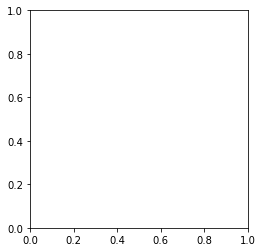

In [56]:
fig,ax = plt.subplots(1)
lab= cv2.cvtColor(image_np, cv2.COLOR_BGR2LAB)
ax.imshow("lab",lab)
plt.show()

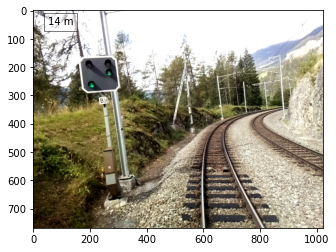

In [39]:
boxes=tlc.detect_multi_object(im_output,score_threshold=0.3)
#save_detected_image(image_np, boxes, results_dir, fn)
fig,ax = plt.subplots(1)
ax.imshow(im_output)
if len(boxes) > 0:
    for box in boxes:
        rect = get_rectangle(im_output, box)
        ax.add_patch(rect)
plt.text(x = 50, y = 50, s = f"{round(dist)} m", bbox=dict(facecolor='white', alpha=0.5))        
plt.show()

In [ ]:
trackdata_raw = pd.read_csv(f"{project_dir}/data/Dataset_complete/Trackdata/TrackSiteData_2020_clean.csv")
trackdata = trackdata_raw[[col for col in trackdata.columns if not "Unnamed" in col]]
signals = trackdata[trackdata["Element Type"].isin(['Distant signal', 'Main & distant signal', 'Main signal'])]

In [ ]:
image_np

In [ ]:
image_geotags = (image_names.map(get_lat_lon(directory_name))

In [ ]:
plt.imshow(image_np[:,:,:3])

In [ ]:
def crop_roi_image(image_np, sel_box):
    im_height, im_width, _ = image_np.shape
    (left, right, top, bottom) = (sel_box[1] * im_width, sel_box[3] * im_width,
                                  sel_box[0] * im_height, sel_box[2] * im_height)
    cropped_image = image_np[int(top):int(bottom), int(left):int(right), :]
    return cropped_image

In [ ]:
boxes[0]

In [ ]:
sel_box = boxes[2]

In [ ]:
fig,ax = plt.subplots(1)
ax.imshow(image_np)
for box in boxes:
    rect = get_rectangle(image_np, box)
    ax.add_patch(rect)
plt.savefig(f'{results_dir}/books_read.png')

In [ ]:
def draw_reactangle_on_image(image_np, sel_box):
    im_height, im_width, _ = image_np.shape
    (left, right, top, bottom) = (sel_box[1] * im_width, sel_box[3] * im_width,
                                  sel_box[0] * im_height, sel_box[2] * im_height)
    cropped_image = image_np[int(top):int(bottom), int(left):int(right), :]
    return cropped_image

In [ ]:
boxes[0]

In [ ]:
boxes=tlc.detect_multi_object(image_np,score_threshold=0.2)

In [ ]:
boxes

In [ ]:
%time
boxes=tlc.detect_multi_object(image_np,score_threshold=0.2)
cropped_image=crop_roi_image(image_np,boxes[0])
plt.imshow(cropped_image)

# Classify the color by human intelligence

The traffic light is very "light". That is, it has high saturation values in HSV space. We can filter the high saturation area, and then classify the color by hue values.

### Convert the cropped image into HSV space

In [ ]:
from skimage.color import rgb2grey,rgb2hsv
hsv_test_image=rgb2hsv(cropped_image)

### Show saturation values

In [ ]:
plt.imshow(hsv_test_image[:,:,1])

We then check the histogram to decide the filtering threshold

In [ ]:
s_val_1d=hsv_test_image[:,:,1].ravel()
plt.hist(s_val_1d,bins=50)
plt.xlabel("saturation")
plt.ylabel("occurences")
plt.show()

### Select the high-saturation region for further classification

In [ ]:
saturation_threshold=0.8
idx = hsv_test_image[:, :, 1] <=saturation_threshold
sat_mask = np.ones_like(hsv_test_image[:, :, 1])
sat_mask[idx] = 0
fig,ax=plt.subplots(nrows=1,ncols=2)
ax[0].imshow(hsv_test_image[:,:,1])
ax[1].imshow(sat_mask)

We perform similar operation for Value channle. This time I used my written function:

In [ ]:
def high_value_region_mask(hsv_image, v_thres=0.6):
    if hsv_image.dtype == np.int:
        idx = (hsv_image[:, :, 2].astype(np.float) / 255.0) < v_thres
    else:
        idx = (hsv_image[:, :, 2].astype(np.float)) < v_thres
    mask = np.ones_like(hsv_image[:, :, 2])
    mask[idx] = 0
    return mask

In [ ]:
v_thres_val=0.9
val_mask=high_value_region_mask(hsv_test_image,v_thres=v_thres_val)
plt.imshow(val_mask)

By performing these two masks, we reach the following mask for selecting the region to calculate the average hue values

In [ ]:
def get_masked_hue_image(hsv_test_image):

    s_thres_val = channel_percentile(hsv_test_image[:, :, 1], percentile=70)
    v_thres_val = channel_percentile(hsv_test_image[:, :, 2], percentile=70)
    val_mask = high_value_region_mask(hsv_test_image, v_thres=v_thres_val)
    sat_mask = high_saturation_region_mask(hsv_test_image, s_thres=s_thres_val)
    masked_hue_image = hsv_test_image[:, :, 0]
    return masked_hue_image

## Filter out the region of interest

In [ ]:
def high_saturation_region_mask(hsv_image, s_thres=0.6):
    if hsv_image.dtype == np.int:
        idx = (hsv_image[:, :, 1].astype(np.float) / 255.0) < s_thres
    else:
        idx = (hsv_image[:, :, 1].astype(np.float)) < s_thres
    mask = np.ones_like(hsv_image[:, :, 1])
    mask[idx] = 0
    return mask


def channel_percentile(single_chan_image, percentile):
    sq_image = np.squeeze(single_chan_image)
    assert len(sq_image.shape) < 3

    thres_value = np.percentile(sq_image.ravel(), percentile)

    return float(thres_value) / 255.0

In [ ]:
hue_image=hsv_test_image[:,:,0]
fig,ax=plt.subplots(nrows=1,ncols=2)
ax[0].imshow(hue_image,cmap='hsv')
ax[0].set_title("hue image")
ax[1].imshow(np.logical_and(sat_mask,val_mask))
ax[1].set_title("mask to be applied")

#TODO!!!!! redraw this image. Use hue color map, make zero values to "black

Note that the following statement is not equivalent to
```
masked_hue_1d= (maksed_hue_image*np.logical_and(val_mask,sat_mask)).ravel()
```
Because zero in hue channel means red, we cannot just set unused pixels to zero.

In [ ]:
hue_1d=hue_image[np.logical_and(val_mask, sat_mask)].ravel()

plt.hist(hue_1d,bins=50)
plt.xlabel("hue")
plt.ylabel("occurences")
plt.show()

The hue values in this region is near 0.5, which is green.

In [ ]:
def get_masked_hue_values(rgb_image):
    """
    Get the pixels in the RGB image that has high saturation (S) and value (V) in HSV chanels

    :param rgb_image: image (height, width, channel)
    :return: a 1-d array
    """

    hsv_test_image = rgb2hsv(rgb_image)
    s_thres_val = channel_percentile(hsv_test_image[:, :, 1], percentile=30)
    v_thres_val = channel_percentile(hsv_test_image[:, :, 2], percentile=70)
    val_mask = high_value_region_mask(hsv_test_image, v_thres=v_thres_val)
    sat_mask = high_saturation_region_mask(hsv_test_image, s_thres=s_thres_val)
    masked_hue_image = hsv_test_image[:, :, 0] * 180
    # Note that the following statement is not equivalent to
    # masked_hue_1d= (maksed_hue_image*np.logical_and(val_mask,sat_mask)).ravel()
    # Because zero in hue channel means red, we cannot just set unused pixels to zero.
    masked_hue_1d = masked_hue_image[np.logical_and(val_mask, sat_mask)].ravel()

    return masked_hue_1d

def convert_to_hue_angle(hue_array):
    """
    Convert the hue values from [0,179] to radian degrees [-pi, pi]

    :param hue_array: array-like, the hue values in degree [0,179]
    :return: the angles of hue values in radians [-pi, pi]
    """

    hue_cos = np.cos(hue_array * np.pi / 90)
    hue_sine = np.sin(hue_array * np.pi / 90)

    hue_angle = np.arctan2(hue_sine, hue_cos)

    return hue_angle



The following codes detects the color by hue values of an image.

In [ ]:
def get_rgy_color_mask(hue_value, from_01=False):
    """
    return a tuple of np.ndarray that sets the pixels with red, green and yellow matrices to be true

    :param hue_value:
    :param from_01: True if the hue values is scaled from 0-1 (scikit-image), otherwise is -pi to pi
    :return:
    """

    if from_01:
        n_hue_value = conver_to_hue_angle_from_01(hue_value)
    else:
        n_hue_value = hue_value

    red_index = np.logical_and(n_hue_value < (0.125 * np.pi), n_hue_value > (-0.125 * np.pi))

    green_index = np.logical_and(n_hue_value > (0.66 * np.pi), n_hue_value < np.pi)

    yellow_index = np.logical_and(n_hue_value > (0.25 * np.pi), n_hue_value < (5.0 / 12.0 * np.pi))

    return red_index, green_index, yellow_index


def classify_color_by_range(hue_value):
    """
    Determine the color (red, yellow or green) in a hue value array

    :param hue_value: hue_value is radians
    :return: the color index ['red', 'yellow', 'green', '_', 'unknown']
    """

    red_index, green_index, yellow_index = get_rgy_color_mask(hue_value)

    color_counts = np.array([np.sum(red_index) / len(hue_value),
                             np.sum(yellow_index) / len(hue_value),
                             np.sum(green_index) / len(hue_value)])

    color_text = ['red', 'yellow', 'green', '_', 'unknown']

    min_index = np.argmax(color_counts)

    return min_index, color_text[min_index]

def classify_color_cropped_image(rgb_image):
    """
    Full pipeline of classifying the traffic light color from the traffic light image

    :param rgb_image: the RGB image array (height,width, RGB channel)
    :return: the color index ['red', 'yellow', 'green', '_', 'unknown']
    """

    hue_1d_deg = get_masked_hue_values(rgb_image)

    if len(hue_1d_deg) == 0:
        return 4, 'unknown'

    hue_1d_rad = convert_to_hue_angle(hue_1d_deg)

    return classify_color_by_range(hue_1d_rad)

In [ ]:
classify_color_cropped_image(cropped_image)

# Put all things together to classify an image

In [ ]:
boxes=tlc.detect_multi_object(image_np,score_threshold=0.1)

In [ ]:
def classify_all_boxes_in_image(image_np, boxes):
    result_index_array = np.zeros(boxes.shape[0], dtype=np.int)
    for i, box in enumerate(boxes):
        cropped_image = crop_roi_image(image_np, box)
        result_color_index, _ = classify_color_cropped_image(cropped_image)
        result_index_array[i] = result_color_index

    return result_index_array

In [ ]:
results_index=classify_all_boxes_in_image(image_np,boxes)

The following function labels the traffic lights. The color of frames correspond to the traffic light colors.

In [ ]:
from vis_util import draw_result_on_image
def draw_results_on_image(image_np, boxes, tl_results_array):
    for i, box in enumerate(boxes):
        draw_result_on_image(image_np, box, tl_results_array[i])

In [ ]:
n_image_np=np.copy(image_np)
draw_results_on_image(n_image_np, boxes, results_index)
plt.imshow(n_image_np)

# Further work
In this work I just some algorithmic way to classify the traffic light color. But this may be replaced by using the training the a machine learning model to do this. An alternative is training this CNN pretrained model to classify the traffic lights.